gives you tools to stear your investigations in the right direction whenever your automatice retraining pipeline looses capacity to deliver ever-better performing model versions.

some circumstances could legitimate to include preprocessing to hyperparam tuning (for instance, to dynamically evaluate different values for "num_feature1/buckets_count" )

in some situations, model blessing can also be conditionnal on carateristics such as "inference latency".

<hr />

# setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
!which python

/home/organization/miniforge3/bin/python


In [3]:
import os, sys, json, itertools

In [4]:
import pandas as pd
import numpy as np

In [5]:
# WandB API key
from dotenv import load_dotenv
load_dotenv("../.env")

True

In [6]:
# adding custom code to path for easy imports
new_path = os.path.realpath(os.path.join(os.getcwd(),
                                         "..", "..", "pkg_src"))
if new_path not in sys.path:
    sys.path.append(new_path)
sys.path

['/home/organization/miniforge3/envs/metaflow_lightgbm/lib/python39.zip',
 '/home/organization/miniforge3/envs/metaflow_lightgbm/lib/python3.9',
 '/home/organization/miniforge3/envs/metaflow_lightgbm/lib/python3.9/lib-dynload',
 '',
 '/home/organization/miniforge3/envs/metaflow_lightgbm/lib/python3.9/site-packages',
 '/mnt/d/jupyter_notebooks/job_hunt/AWS/fresh_start/pkg_src']

In [7]:
import sys
os.environ['conda_env'] = os.path.basename(sys.prefix)
os.environ['conda_env']

'metaflow_lightgbm'

In [8]:
mf_flow_name = 'LightGbmHpCvWandbFlow'
mf_flow_name

'LightGbmHpCvWandbFlow'

In [0]:
from IPython import get_ipython

def reset_jupyter_history():
    """
    reset cell numbering
    """

    import os
    import sqlite3
    from traitlets.config import Config
    from IPython.core.history import HistoryManager
    
    ip = get_ipython()
    
    if ip is not None:
        # Disable history temporarily
        if hasattr(ip, 'history_manager'):
            ip.history_manager.enabled = False
        
        # Get the path to the history database
        hist_file = os.path.expanduser('~/.ipython/profile_default/history.sqlite')
        if hasattr(ip, 'history_manager') and hasattr(ip.history_manager, 'hist_file'):
            hist_file = ip.history_manager.hist_file
        
        if os.path.exists(hist_file):
            # Close any existing connection
            if hasattr(ip, 'history_manager') and hasattr(ip.history_manager, 'db') and ip.history_manager.db is not None:
                ip.history_manager.db.close()
            
            # Truncate the database
            conn = sqlite3.connect(hist_file)
            conn.execute("DELETE FROM history")
            conn.execute("DELETE FROM sqlite_sequence WHERE name='history'")
            conn.commit()
            conn.close()
        
        # Create a new Config object
        c = Config()
        c.HistoryManager.hist_file = hist_file
        
        # Create a new HistoryManager instance
        new_history_manager = HistoryManager(shell=ip, config=c)
        
        # Assign the new history manager to the shell
        ip.history_manager = new_history_manager
        
        # Enable history
        ip.history_manager.enabled = True

        ip.kernel.shell.execution_count = 0
        
        print("Jupyter history has been reset.")
    else:
        print("This function must be run within a Jupyter notebook.")

reset_jupyter_history()
get_ipython().kernel.shell.execution_count

Jupyter history has been reset.


0

<hr />

# Generate data

In [ ]:
from retrain_pipelines.dataset import DatasetType, pseudo_random_generate

num_samples = 1_500 # 10_000 # 30 # 500 # 
data = pseudo_random_generate(DatasetType.TABULAR_REGRESSION, num_samples)

print(data.head())
#data.to_csv(os.path.realpath(os.path.join('..', 'data', 'synthetic_classif_tab_data_continuous.csv')), index=False)

In [ ]:
#from sklearn.preprocessing import OrdinalEncoder
#
#os.environ["ml_pipeline_type"] = "lightgbm_regress_tempo"
#
#from retrain_pipelines.model import preprocess_data_fct
#
#encoder = OrdinalEncoder()
#pp_data = preprocess_data_fct(
#    data, encoder,
#    buckets={'num_feature1': [-1.002, -0.6, -0.19999999999999996, 0.20000000000000018, 0.6000000000000001, 1.0],
#             'num_feature2': 15},
#    is_training=True)
#
#del os.environ["ml_pipeline_type"]
#display(pp_data)
#display(encoder)

In [ ]:
from retrain_pipelines.dataset import features_desc
pd.DataFrame([features_desc(data)])

In [ ]:
from retrain_pipelines.dataset import features_distri_plot
display(features_distri_plot(data))

In [ ]:
from retrain_pipelines.dataset.features_dependencies import dataset_to_heatmap_fig
heatmap_fig, ax = dataset_to_heatmap_fig(data)
heatmap_fig.patch.set_facecolor((1.0, 1.0, 1.0, 0.6))
display(heatmap_fig)

In [94]:
from io import BytesIO
bytes_io_obj = BytesIO()
heatmap_fig.savefig(bytes_io_obj, format='png',
                    bbox_inches='tight', pad_inches=0.05)

bytes_io_obj.seek(0)
with open('figure.png', 'wb') as f:
    f.write(bytes_io_obj.getvalue())

<hr />

# Metaflow Run

Chosse which domain shall be considered for the HP tuning grid search&nbsp;:

In [1]:
pipeline_hp_grid = {
    "boosting_type": ["gbdt"],
    "num_leaves": [10],
    "learning_rate": [0.01],
    "n_estimators": [2],
}
os.environ['pipeline_hp_grid'] = str(json.dumps(pipeline_hp_grid)).replace("\n", "")
print(os.environ['pipeline_hp_grid'])

{"boosting_type": ["gbdt"], "num_leaves": [10], "learning_rate": [0.01], "n_estimators": [2]}


In [ ]:
pipeline_hp_grid = {
    "boosting_type": ["gbdt"],
    "num_leaves": [75, 100, 125],
    "learning_rate": [0.01],
    "n_estimators": [50],
    "lambda_l1": [0, 0.05],
    "lambda_l2": [0.1, 0.2, 0.3],
    "bagging_fraction": [1, 0.95],
}
os.environ['pipeline_hp_grid'] = str(json.dumps(model_hp_grid))
print(os.environ['pipeline_hp_grid'])
len([dict(zip(model_hp_grid.keys(), v))
     for v in itertools.product(*model_hp_grid.values())])

## Run flow

In [2]:
%load_ext retrain_pipelines.local_launcher_magic

The retrain_pipelines.local_launcher_magic extension is already loaded. To reload it, use:
  %reload_ext retrain_pipelines.local_launcher_magic


In [3]:
%retrain_pipelines_local retraining_pipeline.py run --help

Couldn't find a 'retrain_pipelines' installation.


In [4]:
%retrain_pipelines_local retraining_pipeline.py run \
    --data_file "../data/synthetic_classif_tab_data_continuous.csv" \
    --buckets_param '{"num_feature1": 100, "num_feature2": 50}' \
    --pipeline_hp_grid "${pipeline_hp_grid}" \
    --cv_folds 2 \
    --wandb_run_mode disabled
#\
    # --max-workers 4 \
    # --dask_partitions 4 \
    #--pipeline_card_artifacts_path "." \
    #--preprocess_artifacts_path "." \

Couldn't find a 'retrain_pipelines' installation.


In [ ]:
%retrain_pipelines_local retraining_pipeline.py resume pipeline_card

# Inspectors

We can programatically interact with the Metaflow service using the `metaflow`python package. To connect the package with our self-hosted metaflow service, we simply need to set a couple environment variables before importing it&nbsp;:

## local Metaflow SDK

In [5]:
from retrain_pipelines.frameworks import local_metaflow as metaflow

In [6]:
metaflow.Task("LightGbmHpCvWandbFlow/897/pipeline_card/27936",  attempt=0)['encoder'].data.__dict__

{'categories': 'auto',
 'dtype': numpy.float64,
 'handle_unknown': 'error',
 'unknown_value': None,
 'encoded_missing_value': nan,
 'min_frequency': None,
 'max_categories': None,
 '_infrequent_enabled': False,
 'n_features_in_': 3,
 'feature_names_in_': array(['categ_feature0', 'bucketized_num_feature1',
        'bucketized_num_feature2'], dtype=object),
 'categories_': [array(['value1', 'value2', 'value3', 'value4', 'value5'], dtype=object),
  array(['bucket001', 'bucket005', 'bucket010', 'bucket015', 'bucket020',
         'bucket025', 'bucket030', 'bucket035', 'bucket040', 'bucket045',
         'bucket050', 'bucket055', 'bucket061', 'bucket065', 'bucket070',
         'bucket075', 'bucket080', 'bucket085', 'bucket090', 'bucket095',
         'bucket100'], dtype=object),
  array(['bucket01', 'bucket04', 'bucket05', 'bucket06', 'bucket07',
         'bucket08', 'bucket09', 'bucket10', 'bucket11', 'bucket12',
         'bucket13', 'bucket14', 'bucket15', 'bucket16', 'bucket17',
         'b

Inspectors are convenience methods that abstract away some of the logic to get access to Metaflow pipeline-run artifacts.

## local custom card explorer

In [6]:
from retrain_pipelines.inspectors import browse_local_pipeline_card

In [7]:
#browse_local_pipeline_card(mf_flow_name, mf_run_id=633, verbose=True)
browse_local_pipeline_card(mf_flow_name)
#browse_local_pipeline_card(mf_run_id=797, verbose=True)

<hr />

## WandB

In [1]:
from retrain_pipelines.inspectors import get_execution_source_code

In [6]:
help(get_execution_source_code)

Help on function get_execution_source_code in module retrain_pipelines.inspectors.wandb:

get_execution_source_code(mf_flow_name: str = None, mf_run_id: int = -1) -> list
    Params:
        - mf_flow_name (str):
            Name of the Metaflow flowspec.
            When "mf_run_id" (below) is omitted,
            this param here is mandatory.
        - mf_run_id (int):
            the id of the Metaflow flow run
            to consider.
            If ommitted, the last flow run
            is considered.
            throws MetaflowInvalidPathspec
            or MetaflowNotFound
    
    Results:
        - (list[wandb.apis.public.files.File])



In [4]:
artifact_files = get_execution_source_code(mf_run_id=978)

for file in artifact_files:
    print(f" - {file.name} {file.url}")
    # file.download(replace=True)

Task('LightGbmHpCvWandbFlow/978/start/29753')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aurelien-morgan (aurelien-morgan_org). Use `wandb login --relogin` to force relogin


v30 ; 2024-09-21T14:25:02Z
 - retraining_pipeline.py https://api.wandb.ai/artifactsV2/gcp-us/aurelien-morgan_org/QXJ0aWZhY3Q6MTI0MDg2OTM5OA==/344fe8216e4fcece320879d829550b03


In [5]:
from retrain_pipelines.inspectors import explore_source_code
# download and open file explorer
explore_source_code(mf_run_id=978)

/mnt/d/jupyter_notebooks/job_hunt/AWS/fresh_start/sample_pipelines/LightGBM_hp_cv_WandB/LightGbmHpCvWandbFlow_978
v30 ; 2024-09-21T14:25:02Z


<hr />

## hp_cv_inspector

The herein retraining pipeline rely on Dask for data-parallel training. Each Cross-Validation fold of each set of hyperparameter value is trained using a subset of the dataset, parallelized accross workers.

We look into pipeline runs from the perspective of detailed training logs during hyperparameter tuning.

First, focusing on the best-performing set of hyperparameters values&nbsp;:

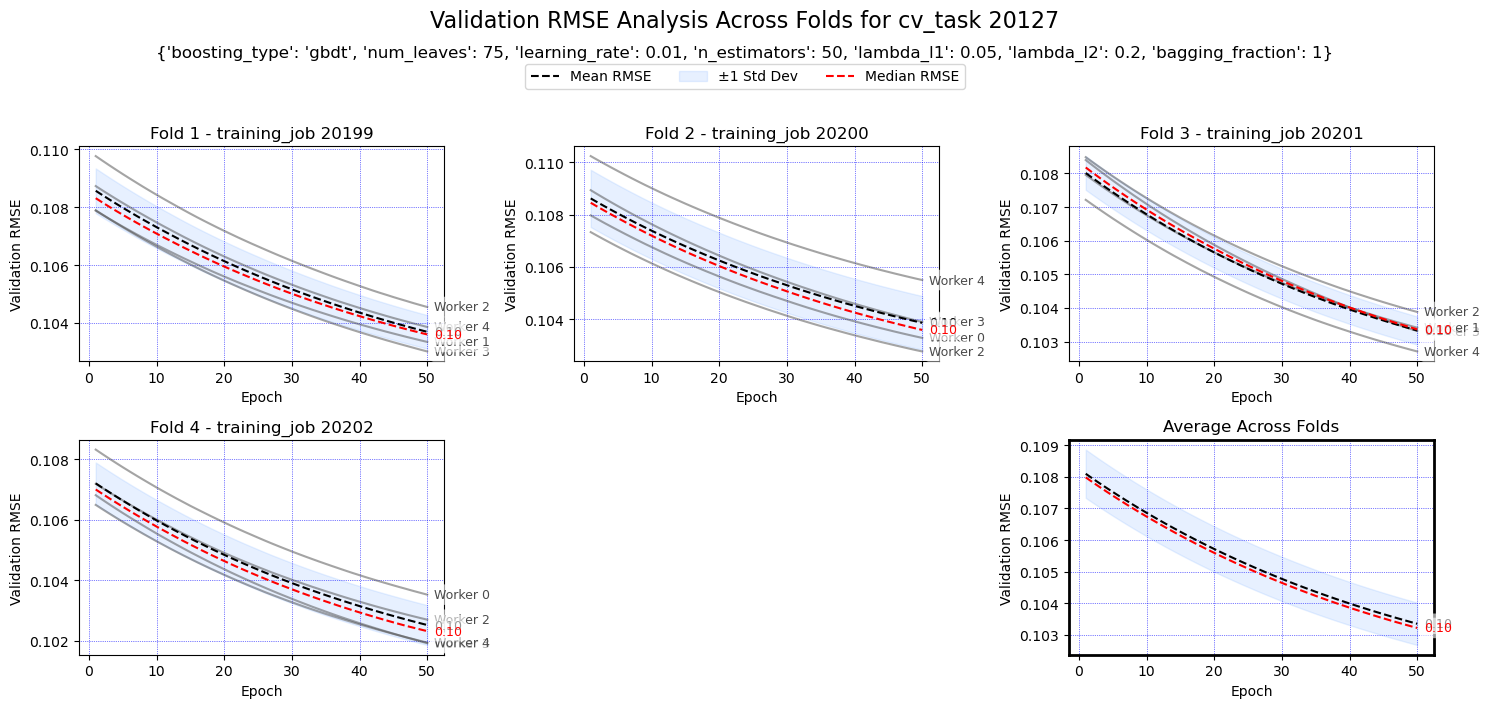

In [13]:
from inspectors import plot_run_cv_history
plot_run_cv_history(best_cv=True) #mf_run_id=432, 

Now, looking at all sets of hyperparameter values evaluated&nbsp;:

run_id 455 ; 24 training_job tasks


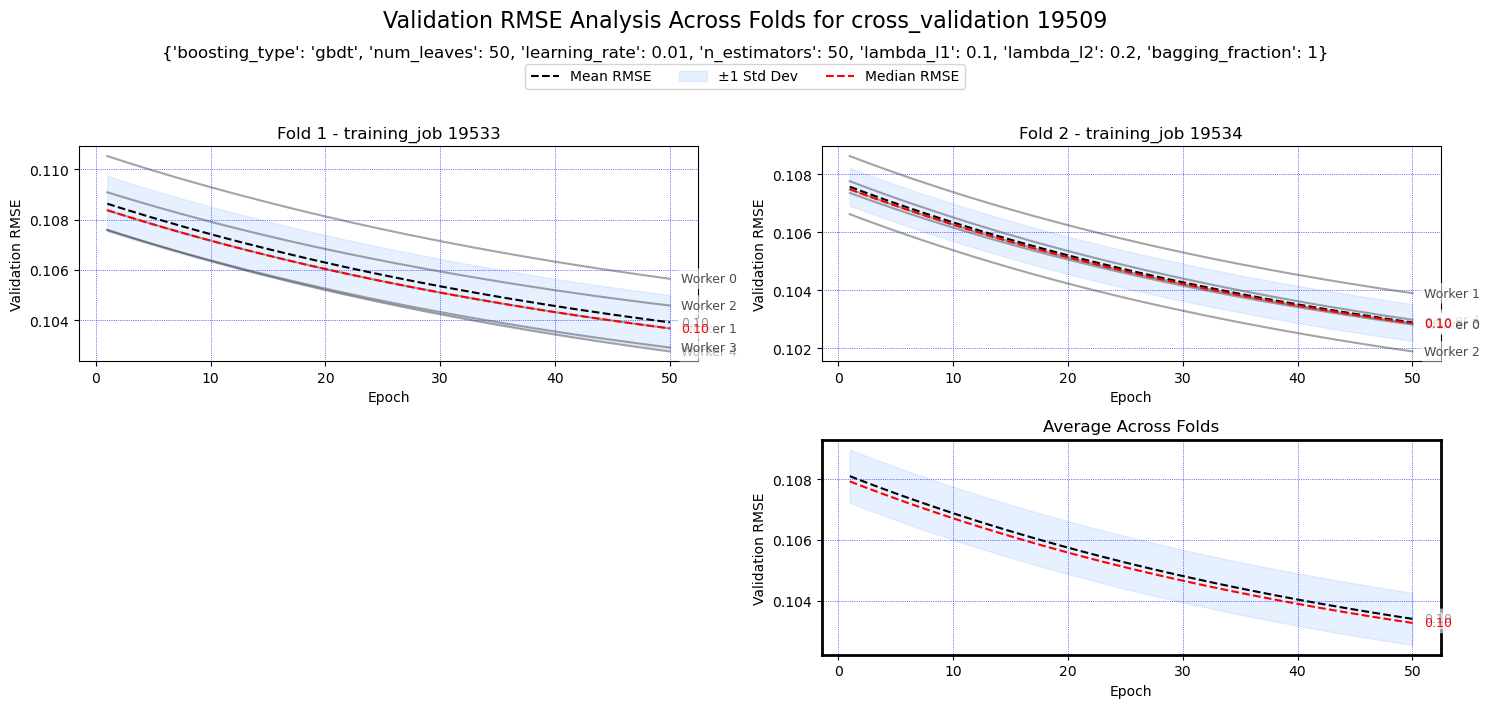

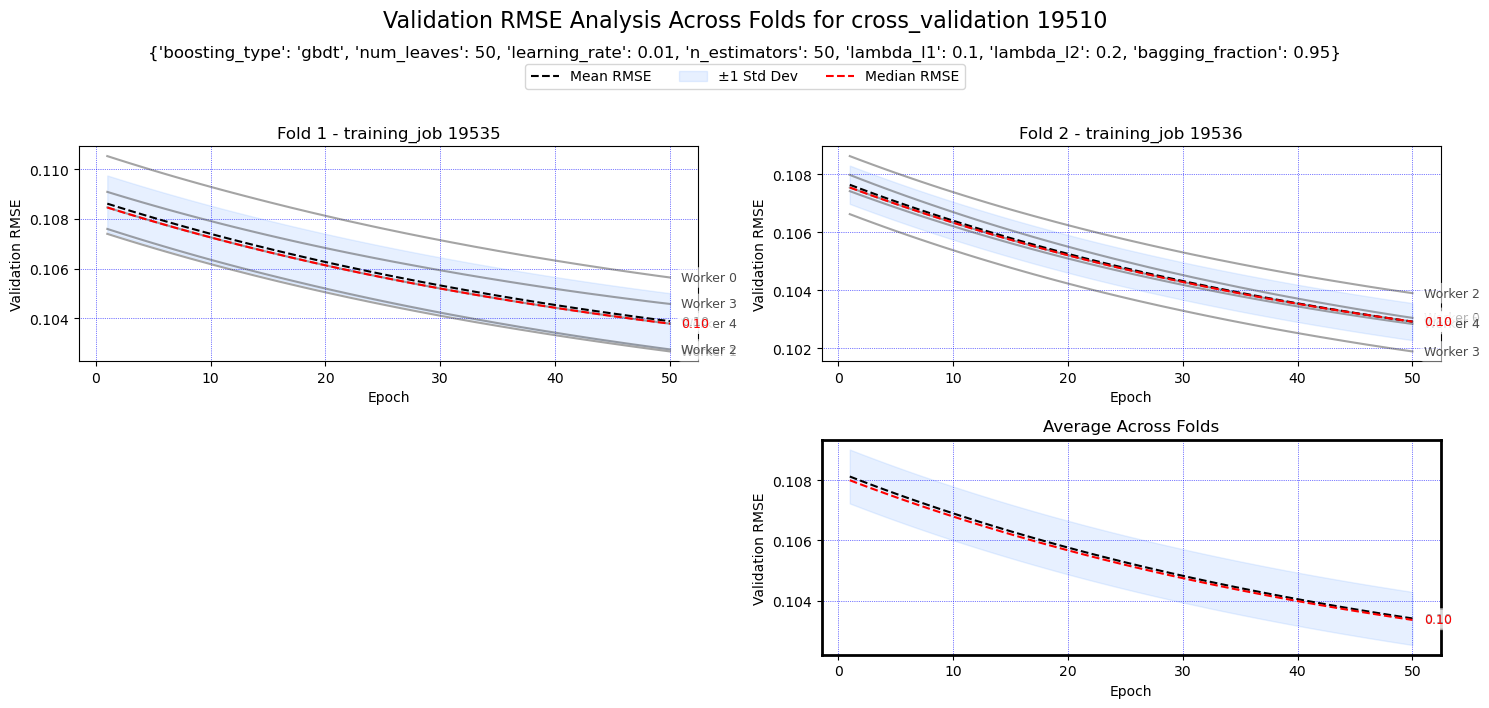

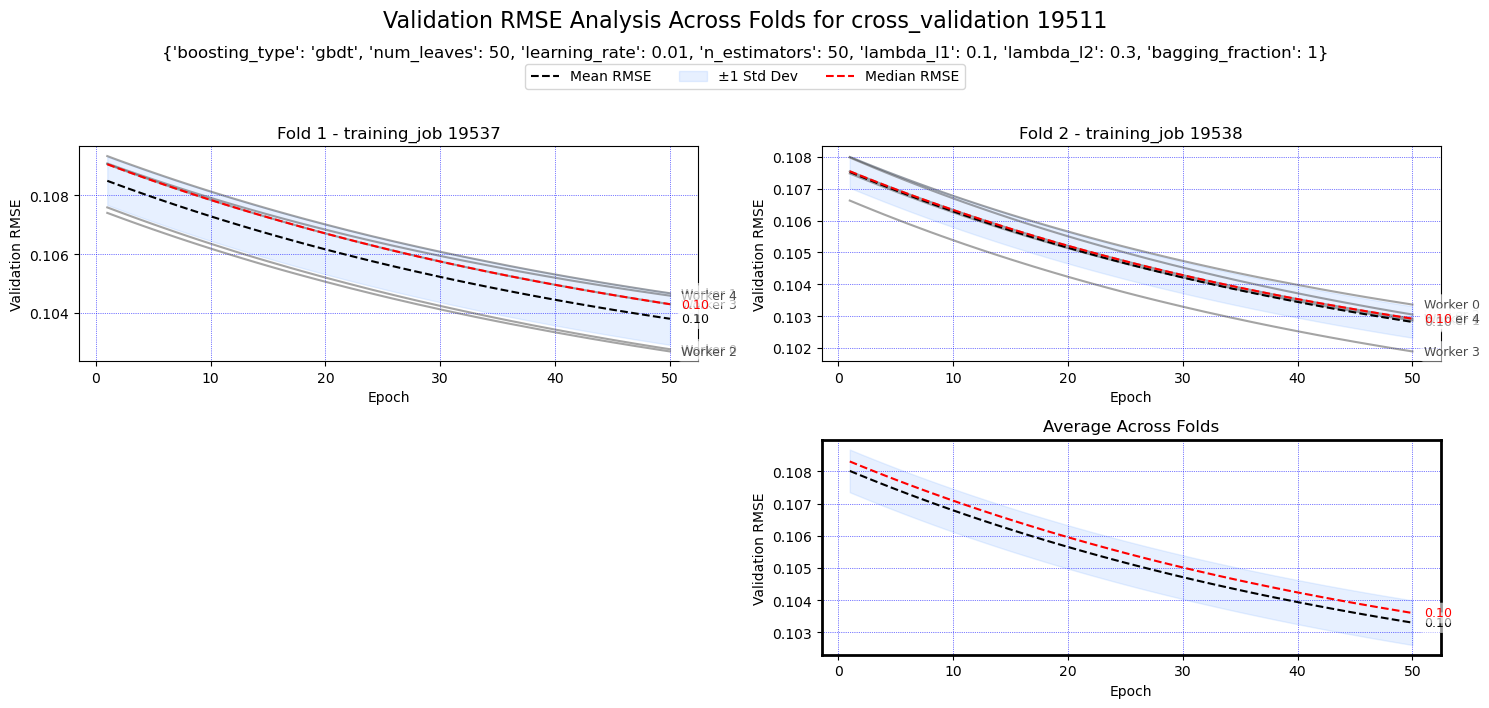

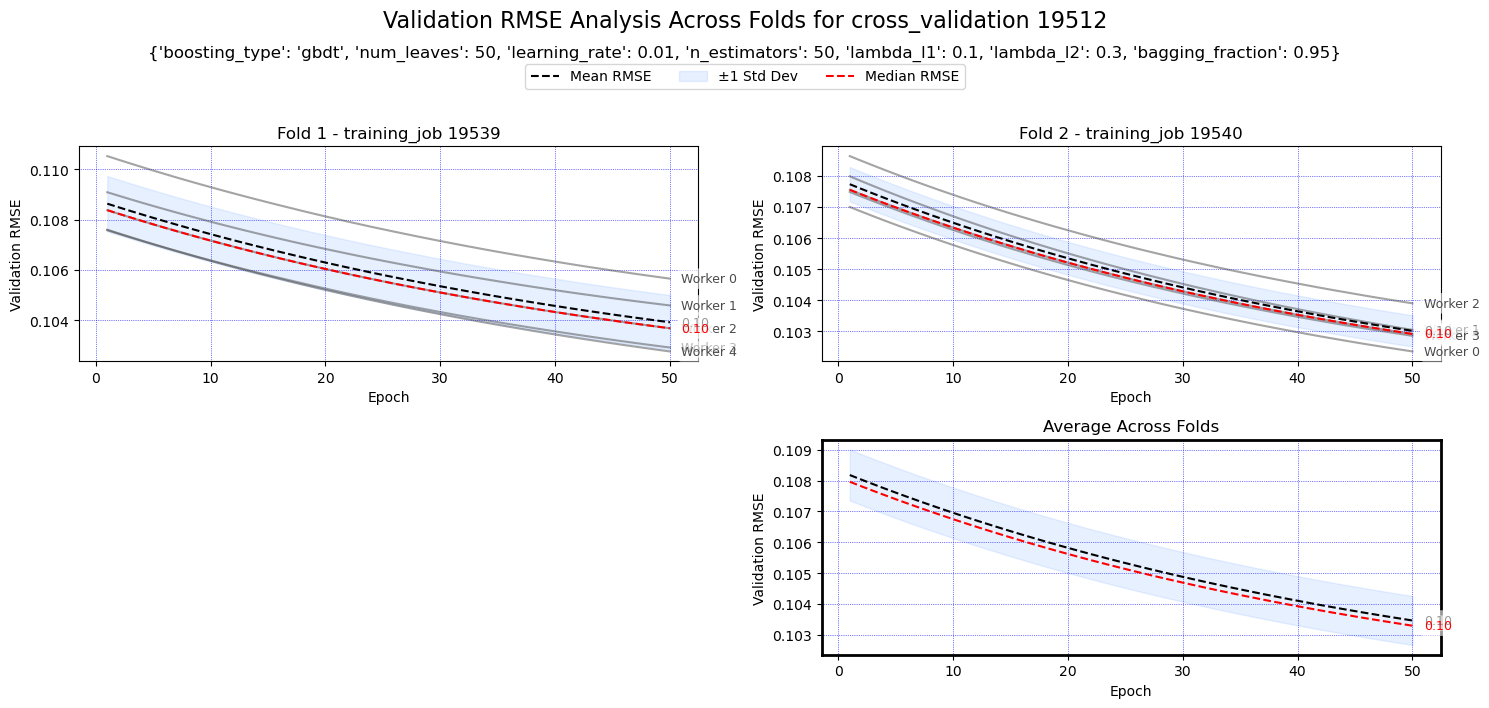

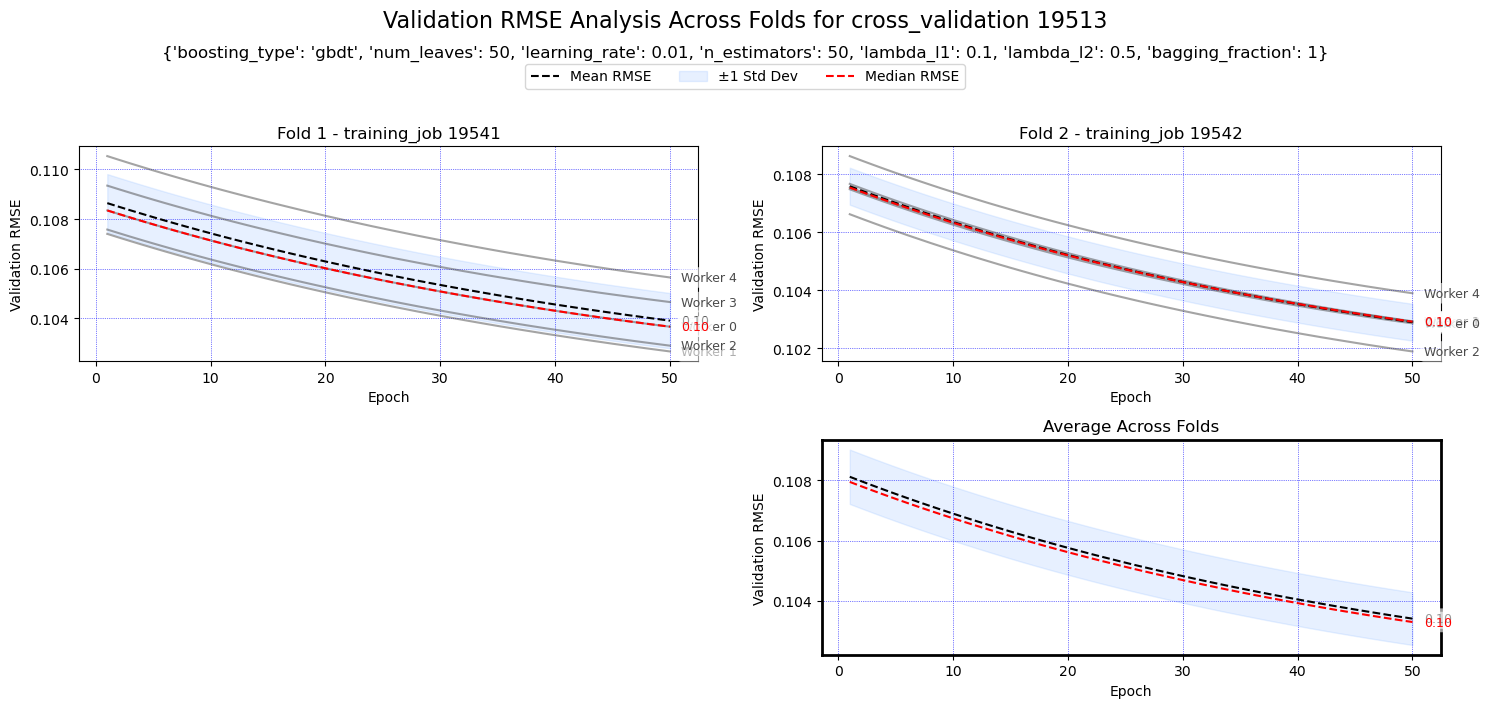

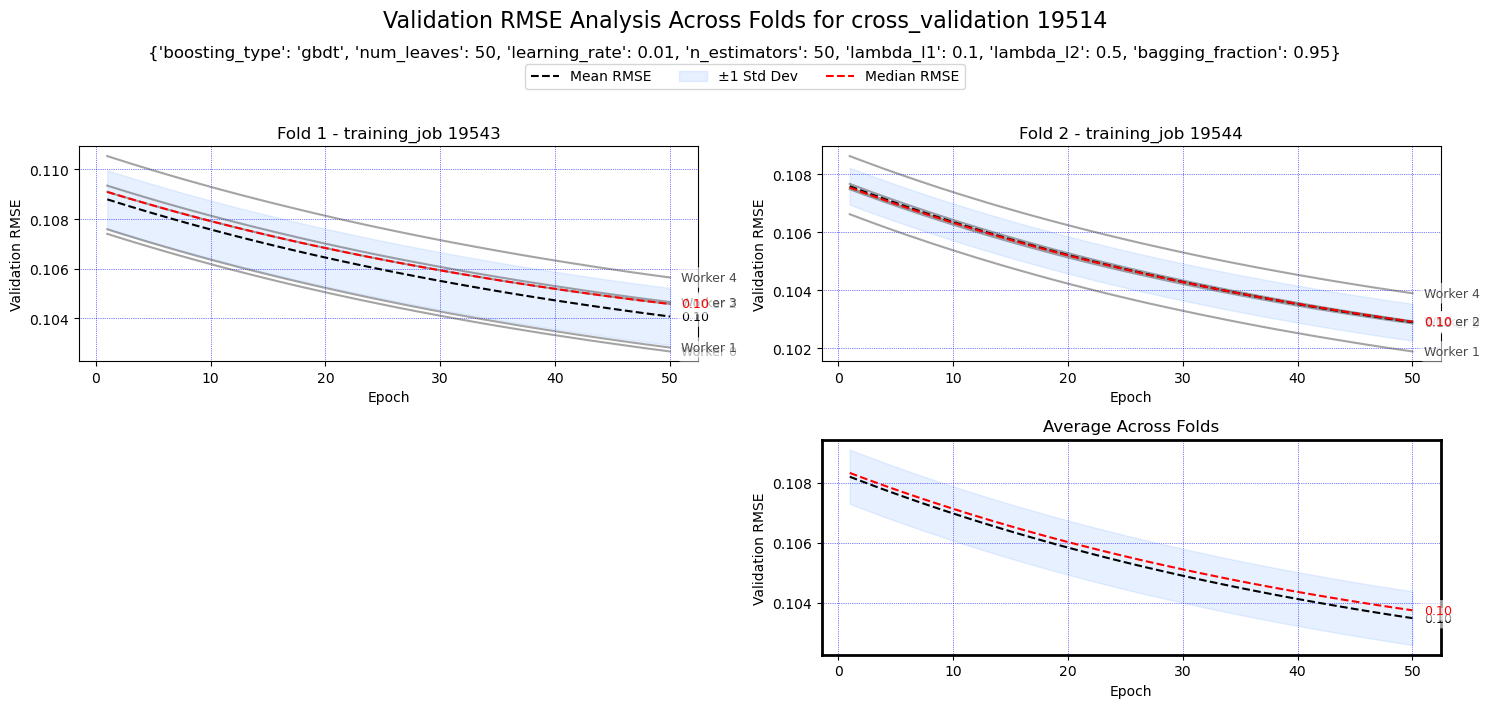

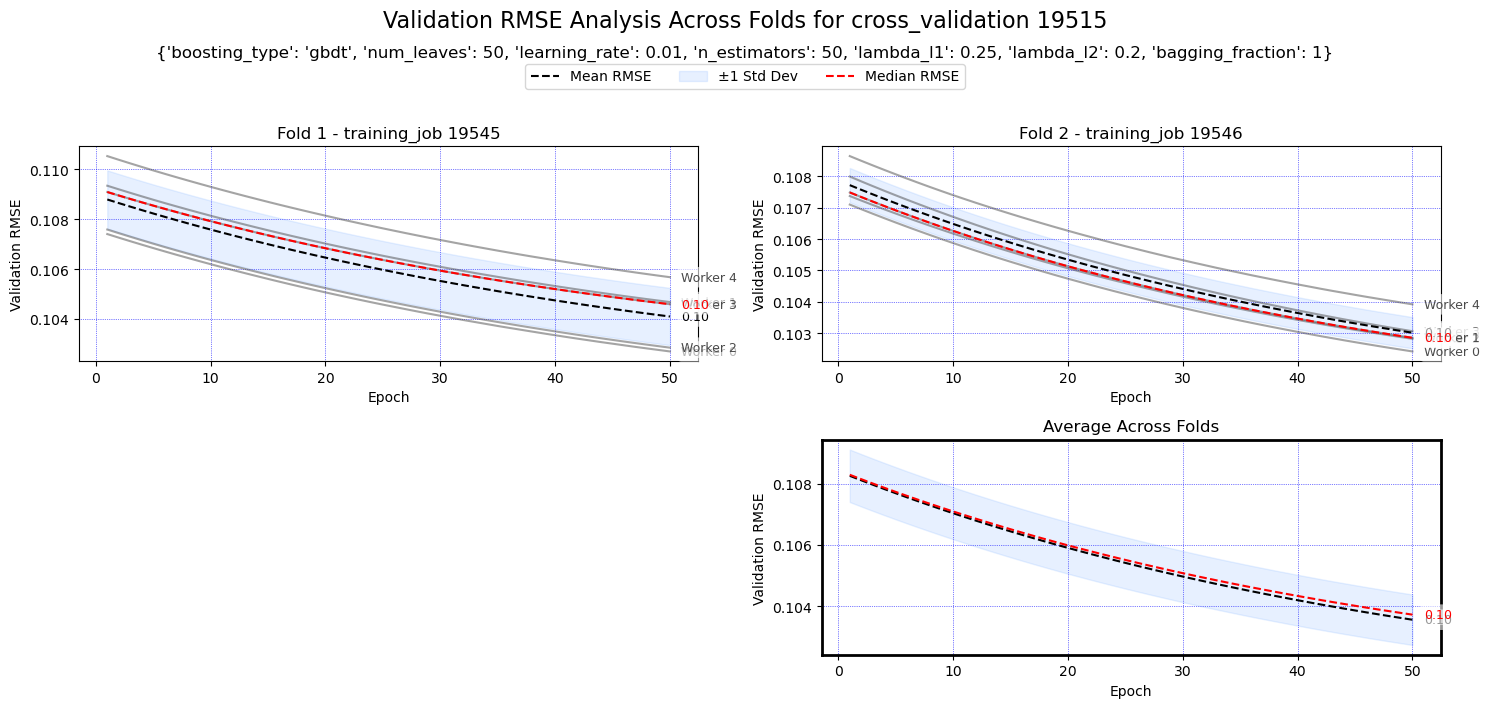

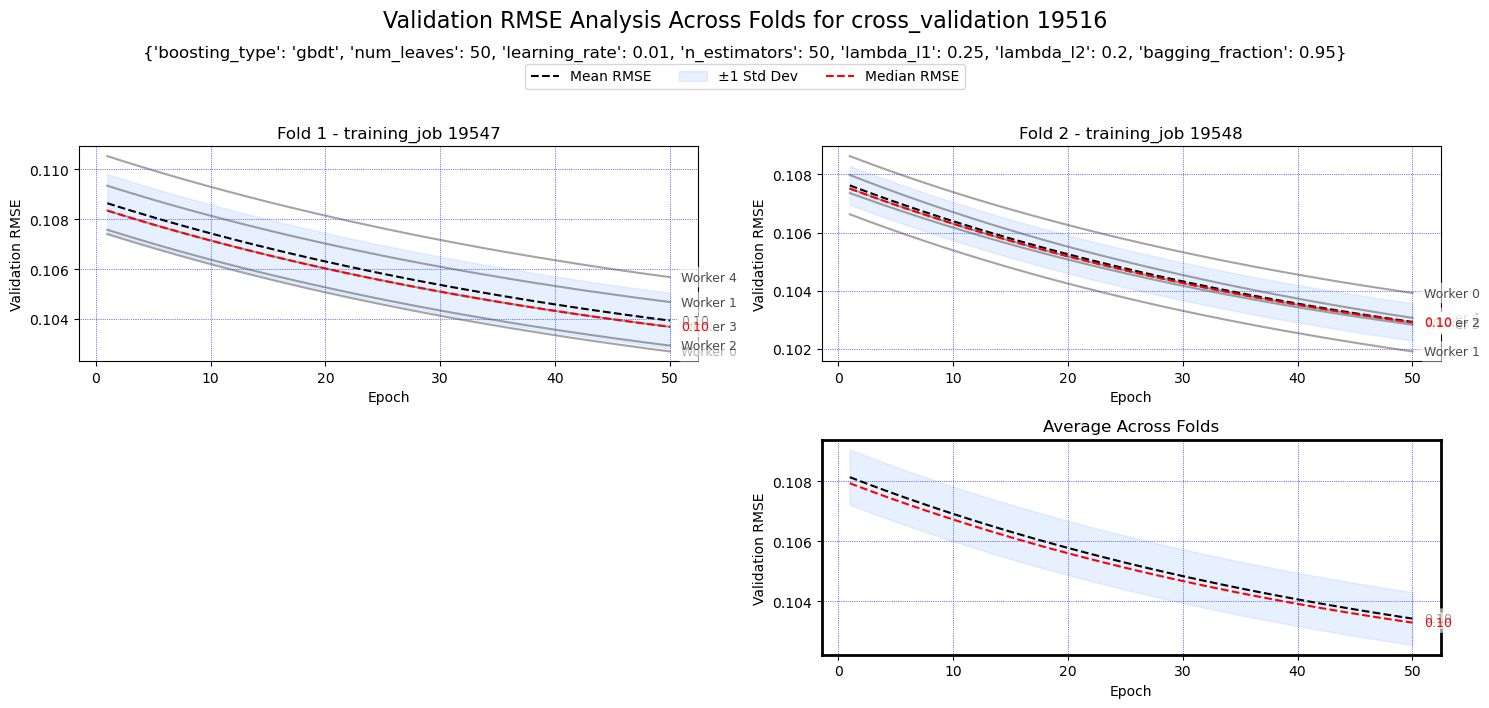

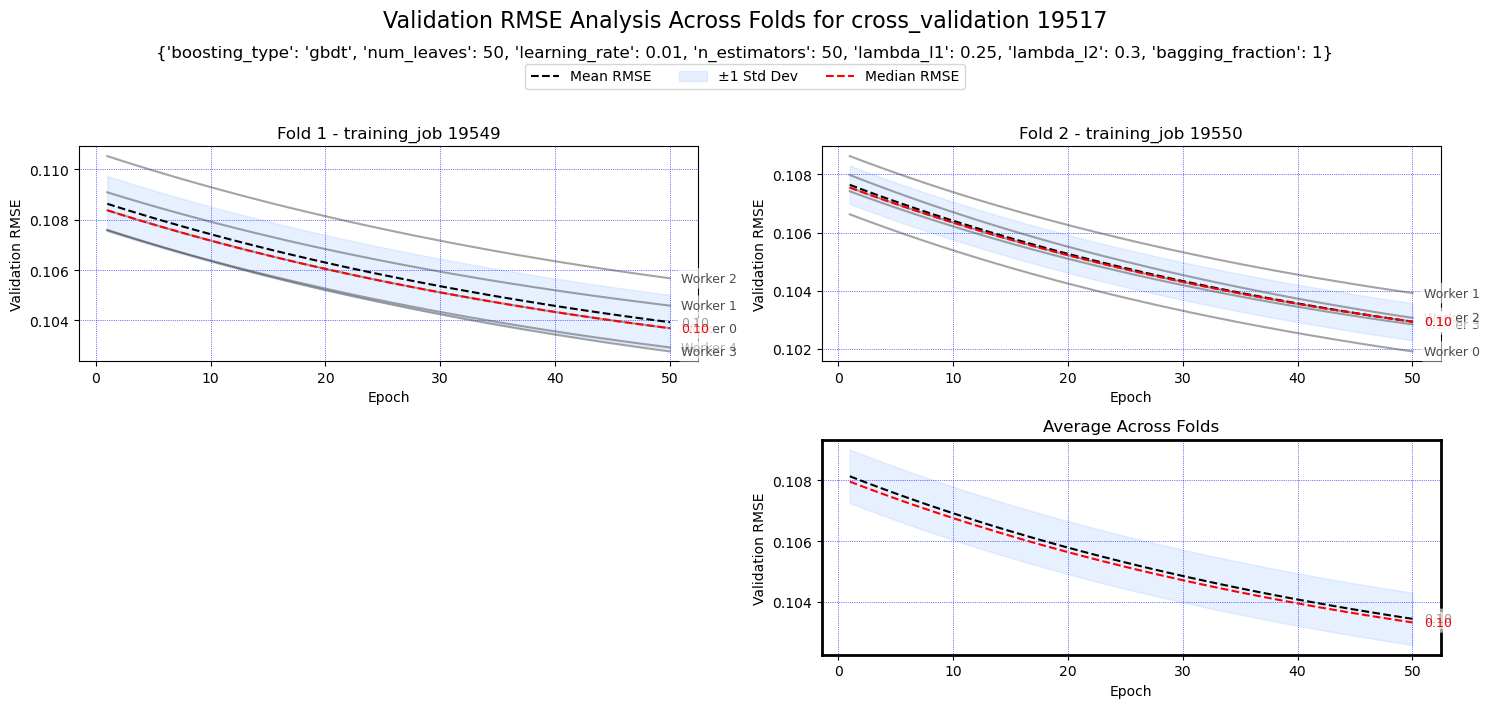

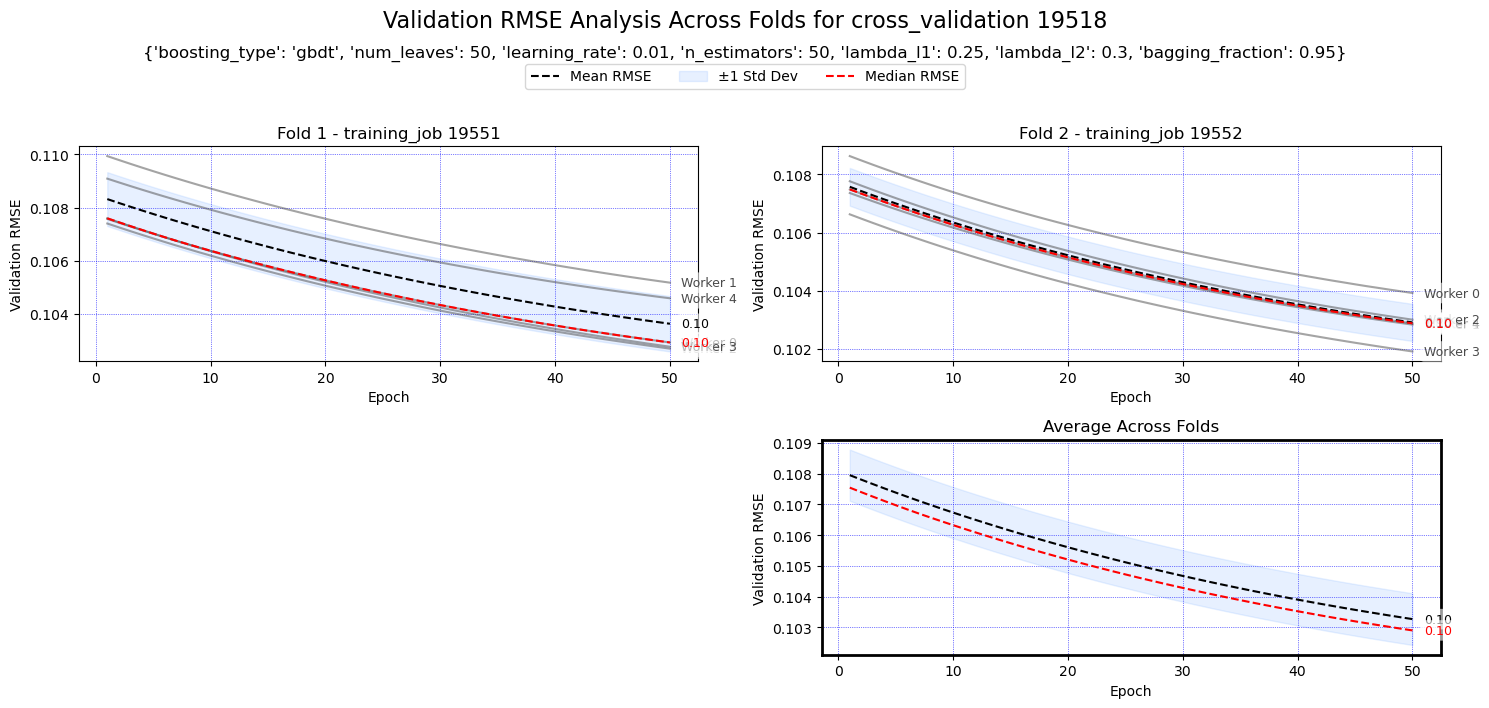

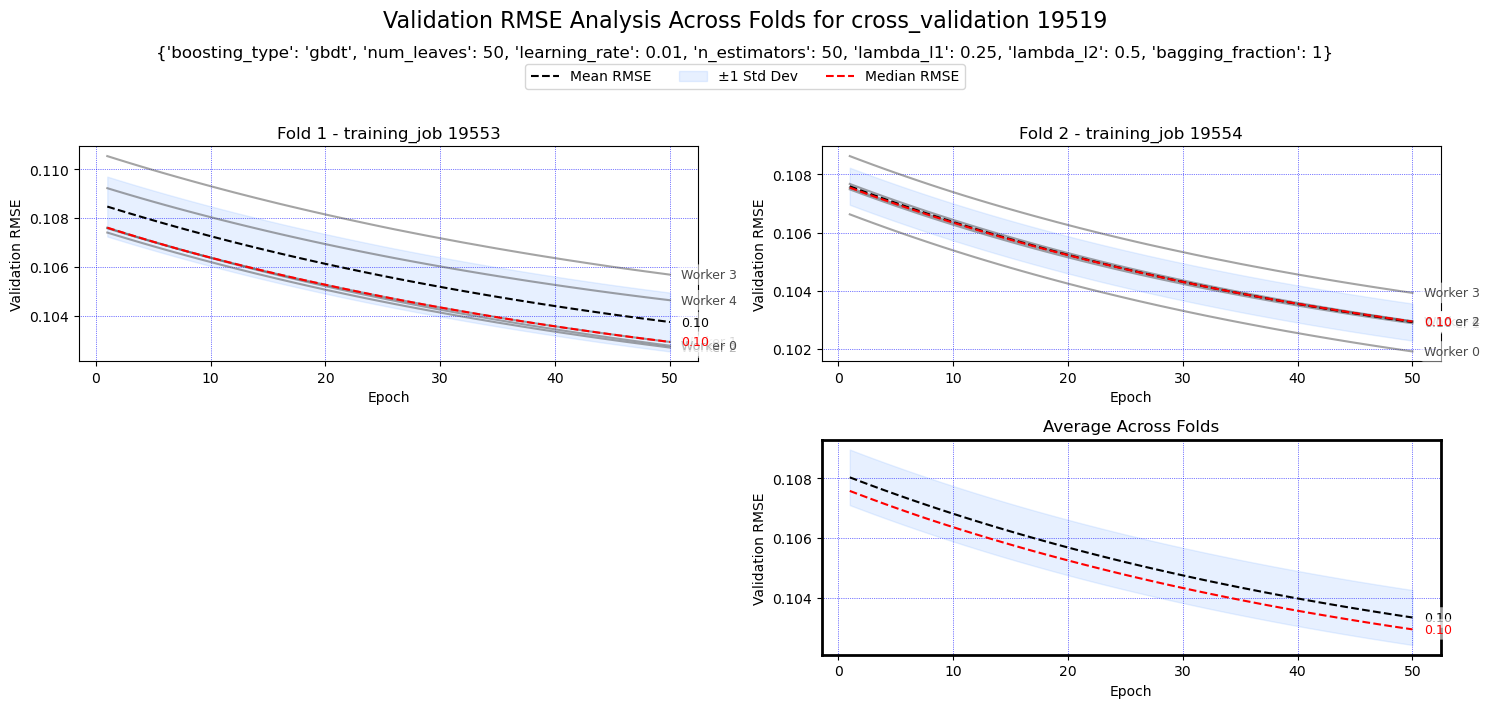

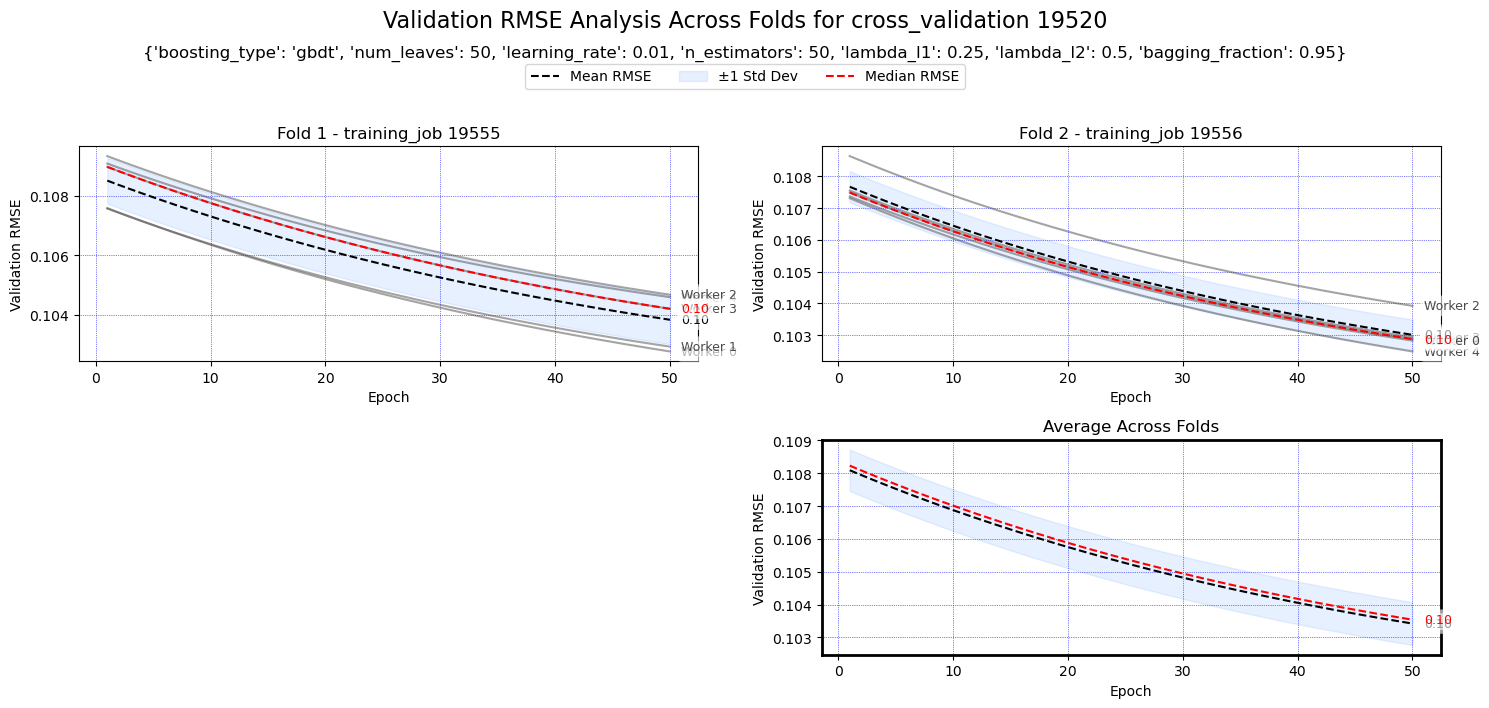

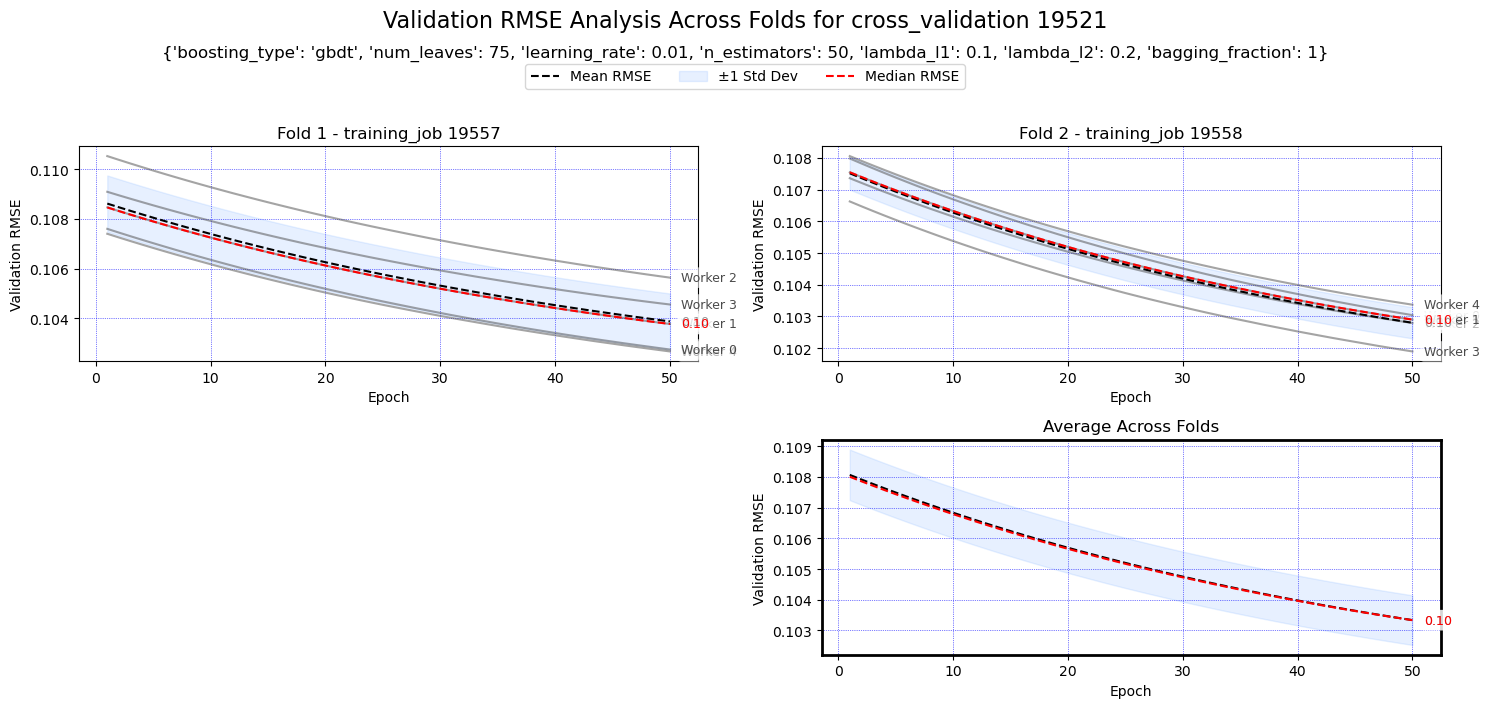

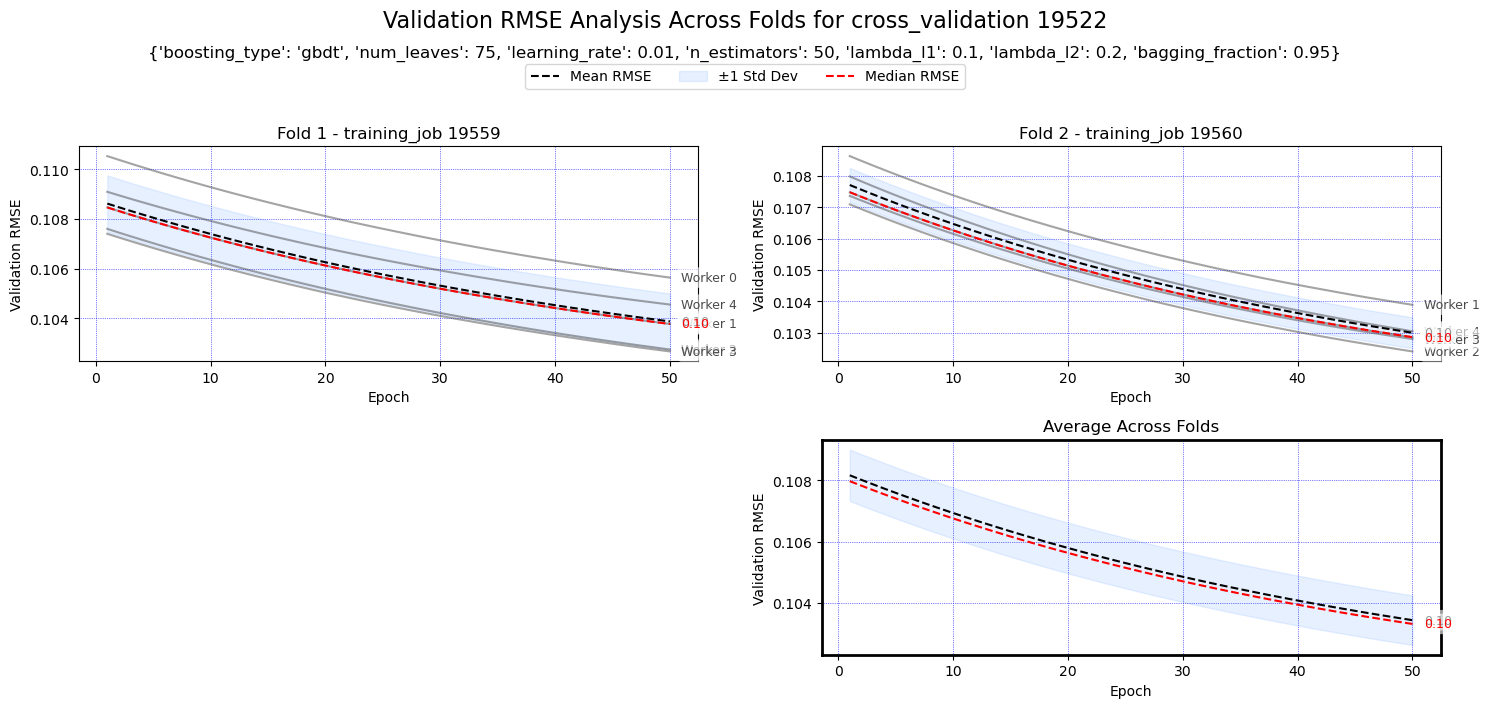

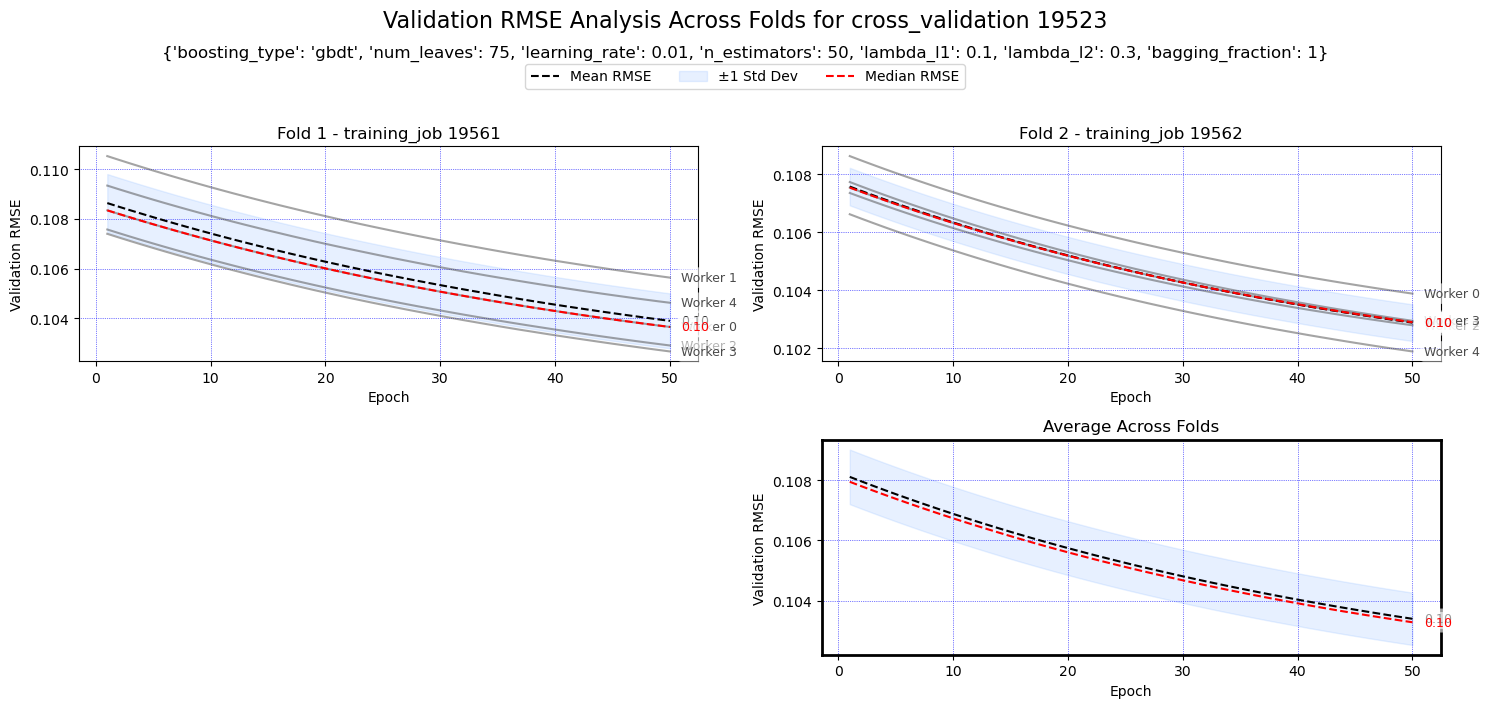

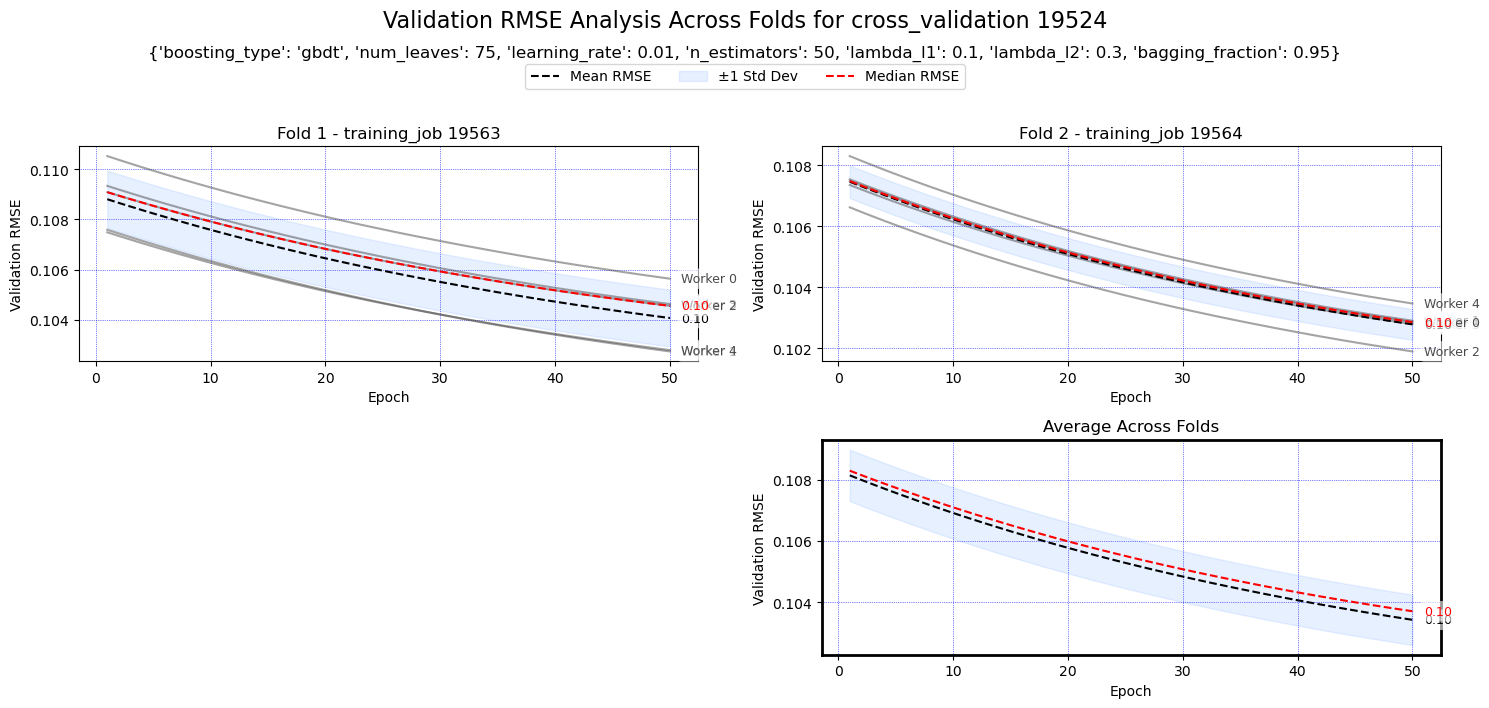

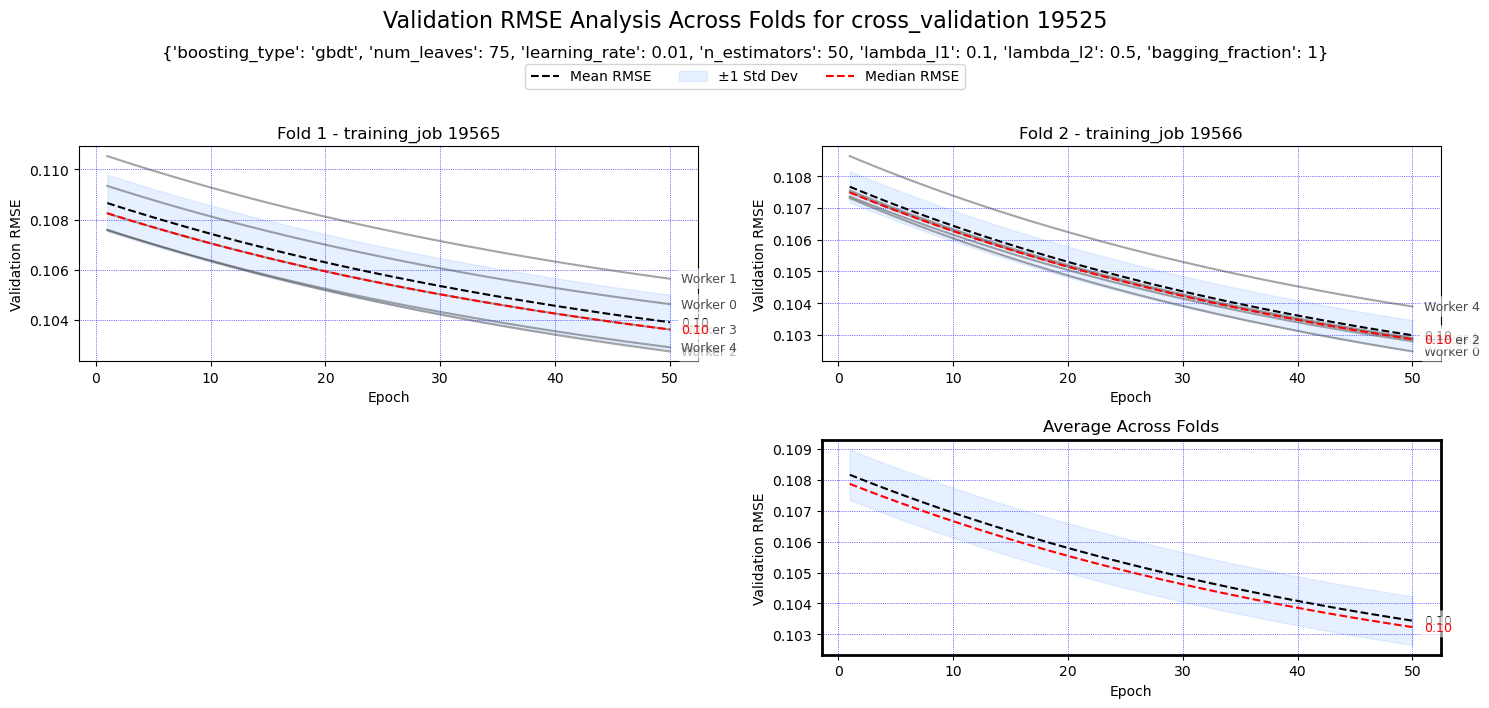

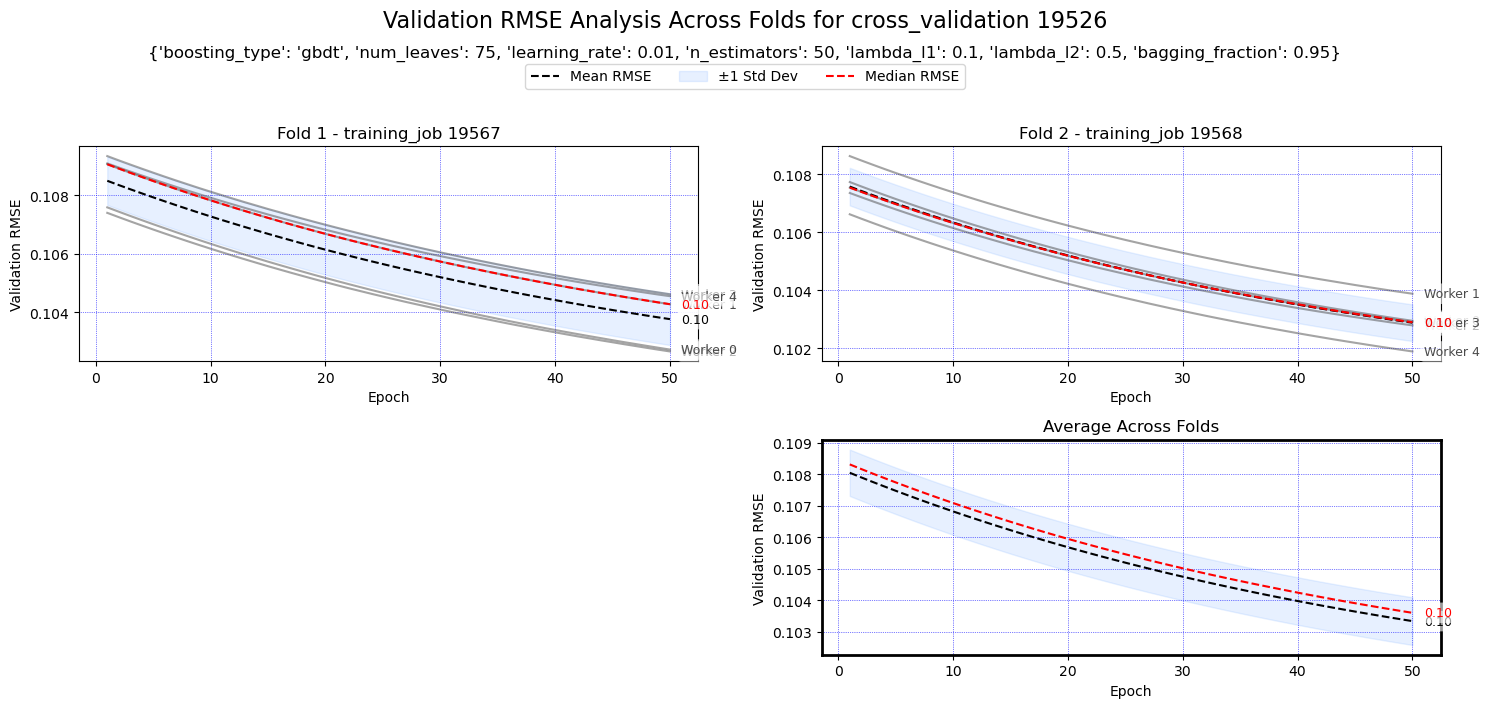

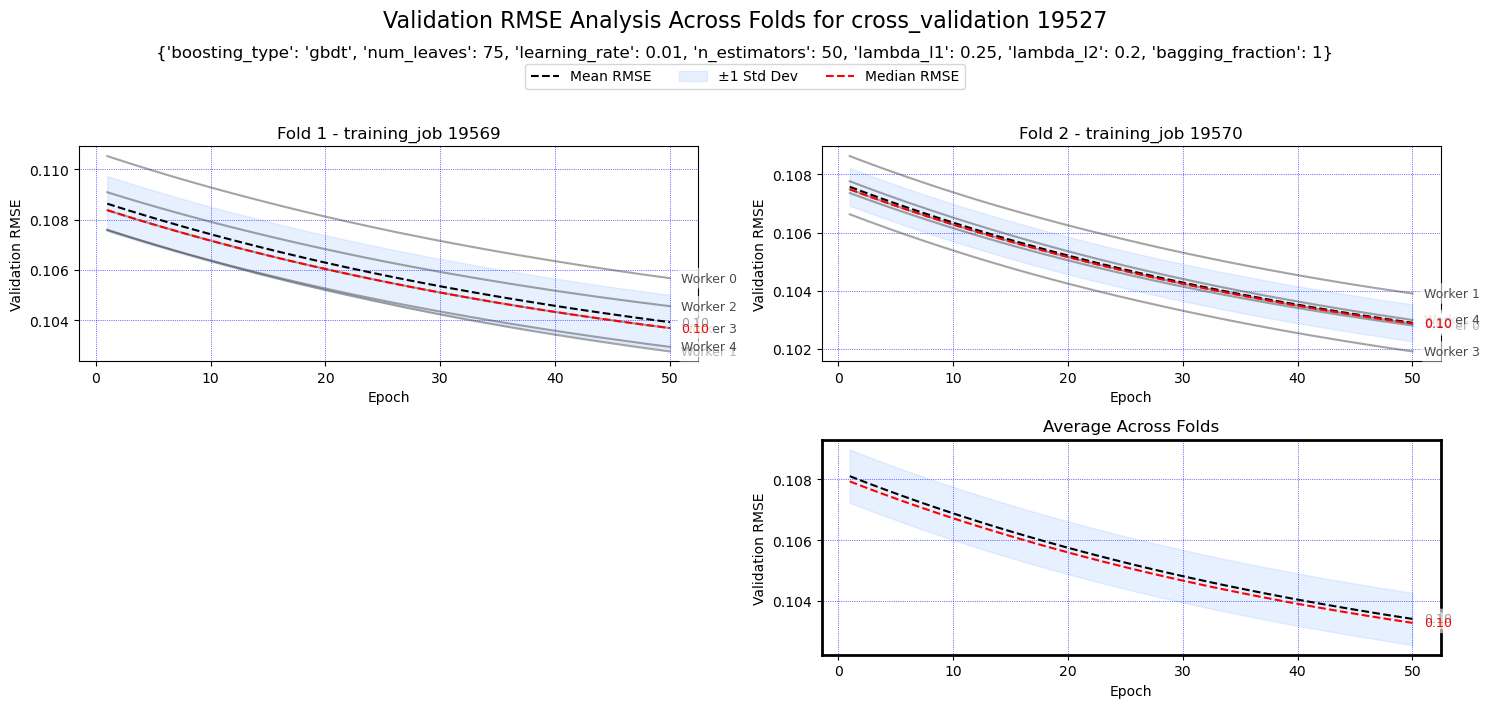

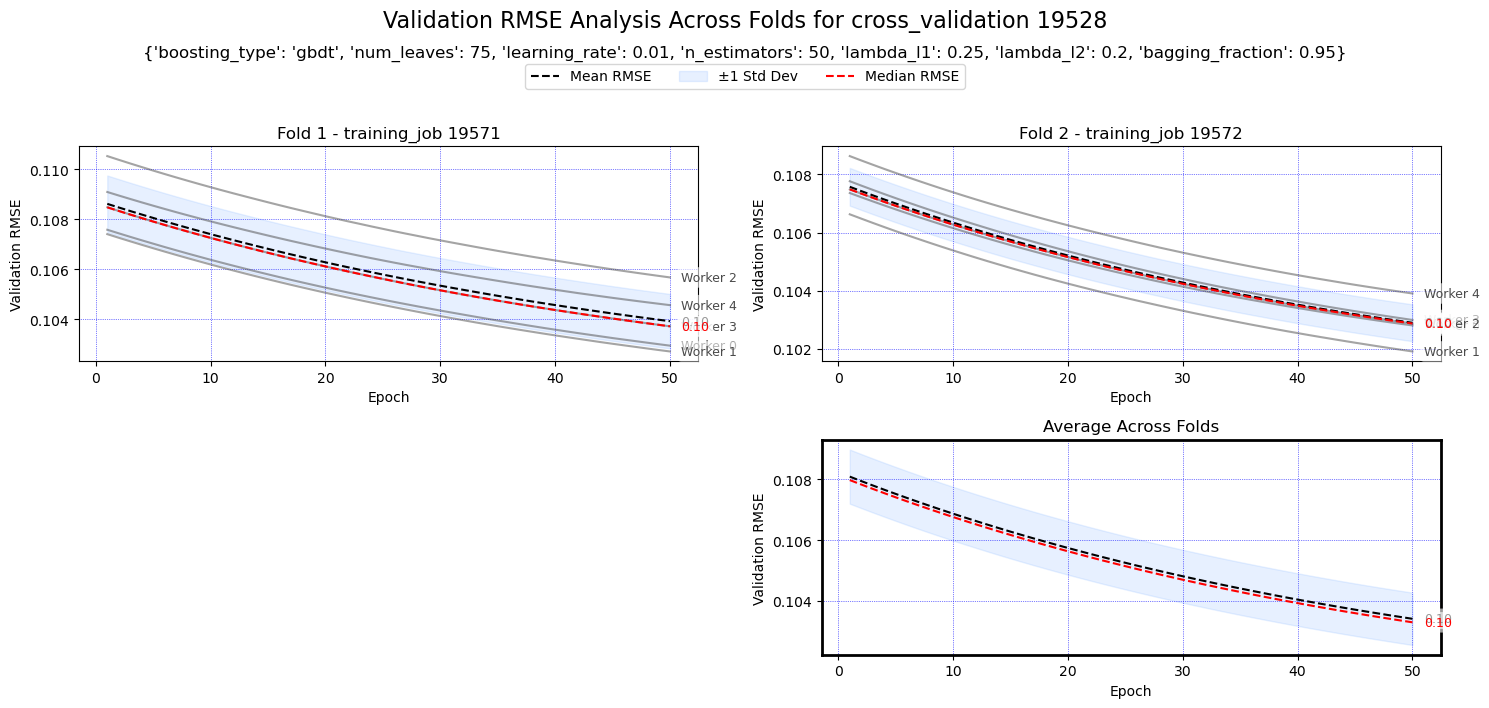

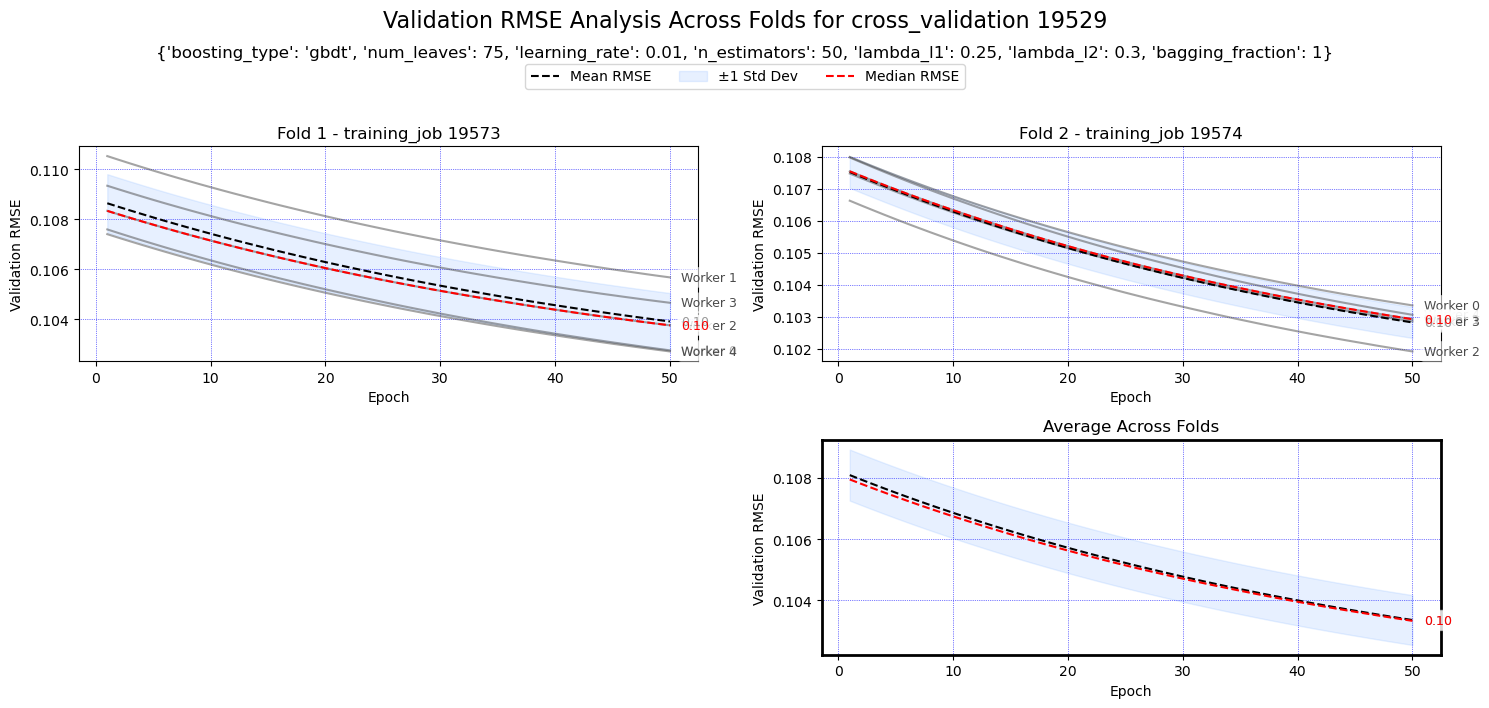

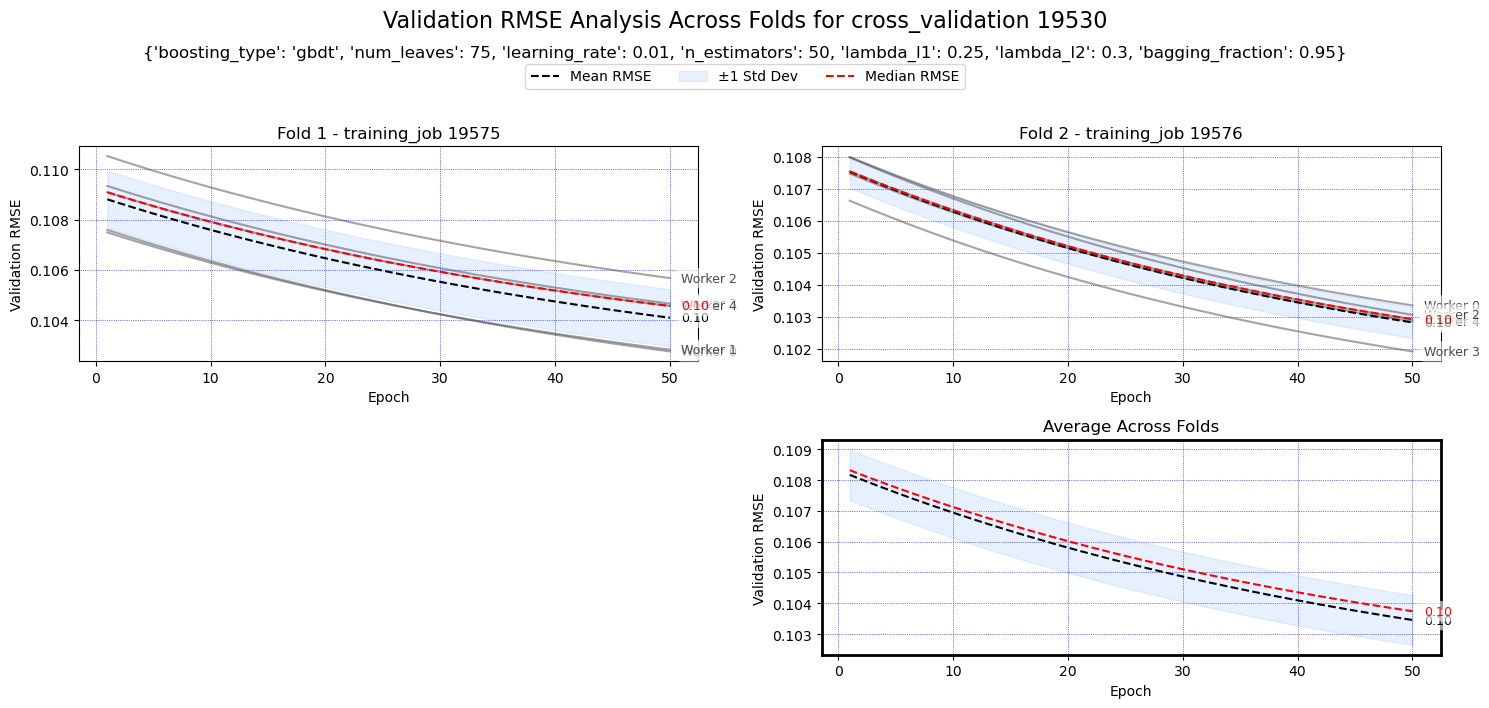

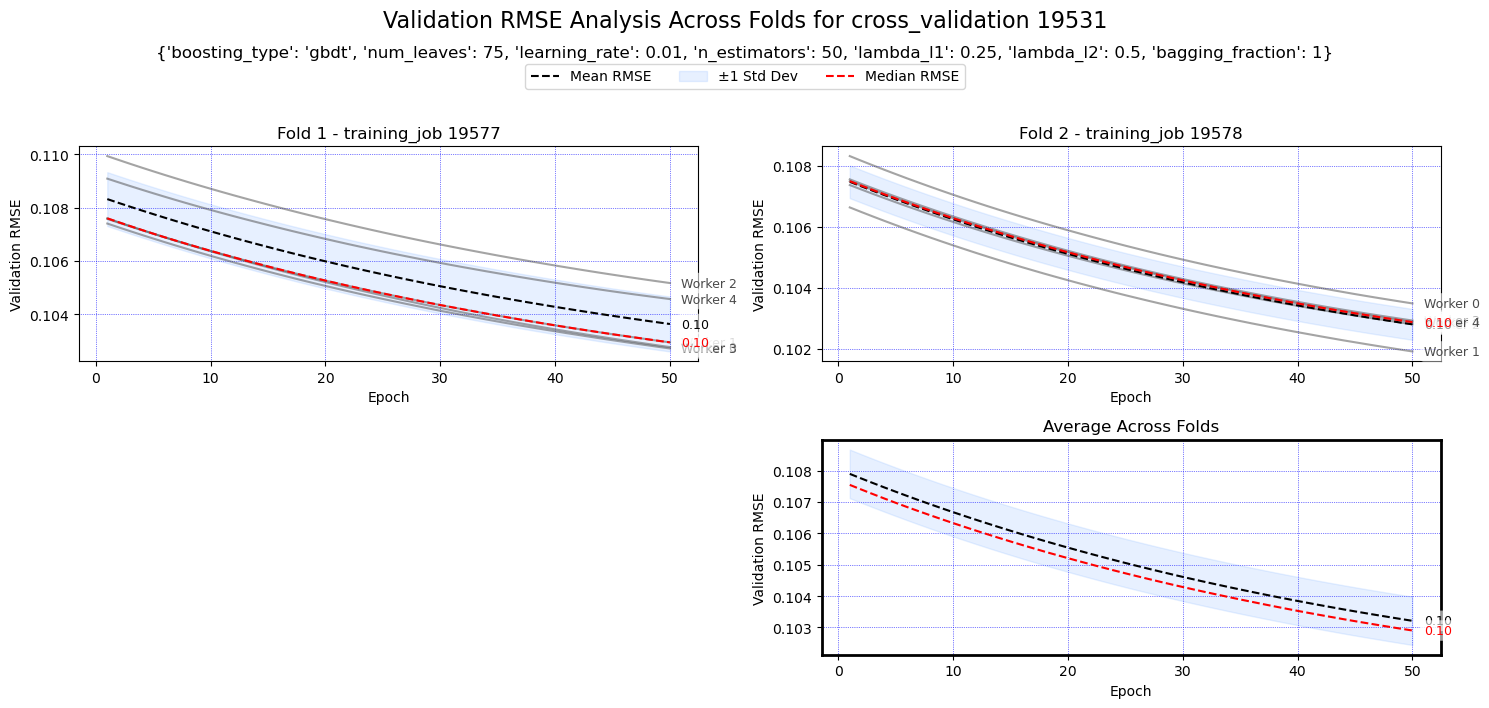

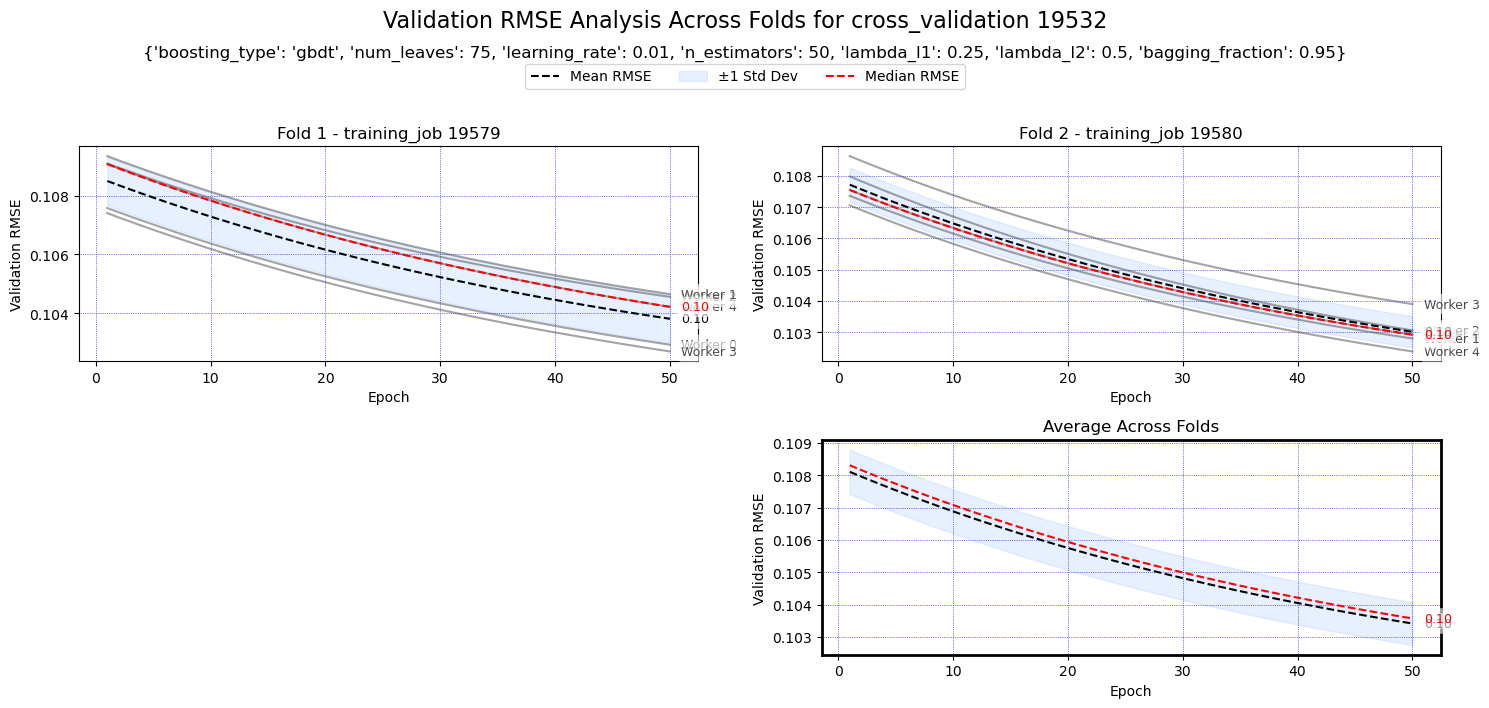

In [25]:
from inspectors import plot_run_all_cv_tasks
plot_run_all_cv_tasks()#mf_run_id=432)

# dependencies

In [188]:
%pip list

Package                       Version
----------------------------- ------------
aiofiles                      23.2.1
aiohttp                       3.8.6
aiokafka                      0.8.0
aiosignal                     1.3.1
anyio                         3.7.1
appdirs                       1.4.4
async-timeout                 4.0.3
asynctest                     0.13.0
attrs                         23.1.0
Authlib                       1.0.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.5
boto3                         1.28.80
botocore                      1.31.80
Brotli                        1.0.9
cachetools                    5.3.2
certifi                       2023.7.22
cffi                          1.15.1
charset-normalizer            3.3.2
click                         8.1.7
cloudpickle                   2.1.0
conda-pack                    0.7.1
cryptography                  41.0.5
cuda-python                   12.0.0
cycler                        0.11.0
Cyth

In [33]:
%pip list --format=freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


# END